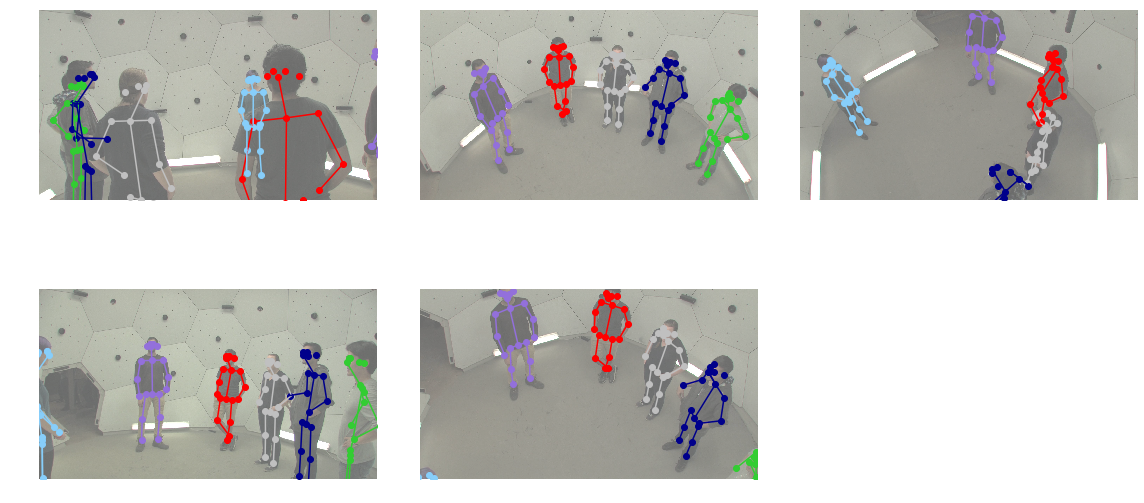

In [23]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import epfl_campus
from time import time

root = Settings['CMU']['data_root']
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d
from mvpose.data import cmu_panoptic
from cselect import color as cs
from random import shuffle


from openpose import OpenPose

FRAME = 9437

nodes = [0, 1, 2, 3, 4]
panels = [0, 0, 0, 0, 0]
#seq_name = '160224_haggling1'
seq_name = '160422_ultimatum1'

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

fig = plt.figure(figsize=(16,8))

# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1


colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen',
         'rosybrown', 'sienna', 'plum', 'slategrey',
         'orchid', 'lightblue', 'azure', 'aliceblue',
         'darkblue', 'lightcoral', 'silver', 'mediumpurple',
         'lightskyblue']
shuffle(colors)

# n = 18
# colors = cs.rangecolor(n, (255, 0, 0), (0, 256, 0))/255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
    for pid, points3d_weighted in Y:
        pts3d = points3d_weighted[:, 0:3].astype('float32')
        pts2d = cam.projectPoints(pts3d)
        pts2dT = pts2d.transpose()
        ax.scatter(pts2d[:, 0], pts2d[:, 1], color=colors[pid])
        for edge in body_edges:
            ax.plot(pts2dT[0, edge], pts2dT[1, edge],
                    color=colors[pid])
    
plt.tight_layout()

plt.show()

found = 2


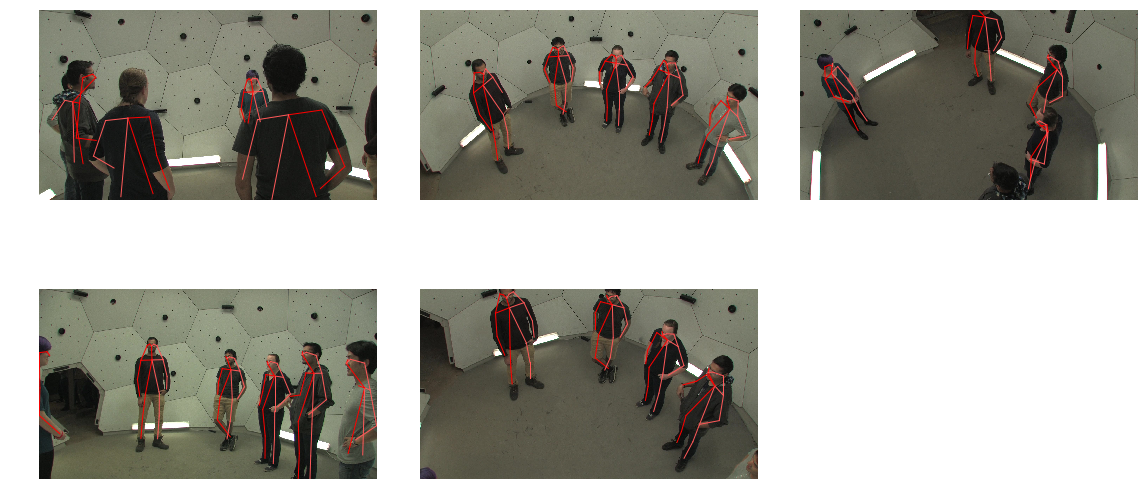

In [26]:
pe = OpenPose(tmp=tmp)
predictions = pe.predict(Im, 'cvpr_cmu', FRAME)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(2, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
    for human in pred:
        draw_mscoco_human2d(ax, human[:, 0:2], color='red')

    
plt.tight_layout()
plt.show()

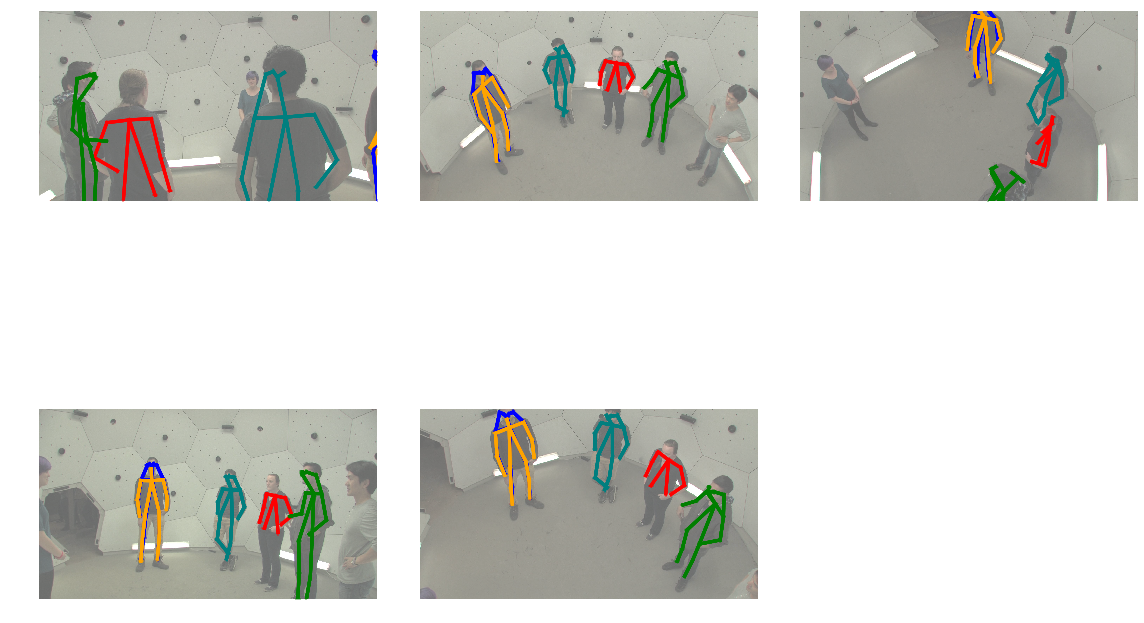

In [29]:
from mvpose.baseline.baseline import estimate

H = estimate(Calib, predictions, epi_threshold=30)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green', 'teal', 'orange', 'white']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()